In [1]:
# ==========================================
# 🧭 BLOC — Exploration des fichiers bruts
# ==========================================
from pathlib import Path
import pandas as pd

# === Chemins ===
DATA = Path("../data_clean")

FILES = {
    "common_FR_long": DATA / "ODISSEE/common_FR_long.csv",
    "common_REG_long": DATA / "ODISSEE/common_REG_long.csv",
    "coviprev_reg_weekly": DATA / "COVIPREV/coviprev_reg_weekly.csv",
    "dpps_fr_weekly": DATA / "COVIPREV/dpps_fr_weekly.csv",
    "vacsi_fr_extended": DATA / "VACSI/vacsi_fr_extended.csv",
    "vacsi_by_age_dep": DATA / "VACSI/donnees-vaccination-par-tranche-dage-type-de-vaccin-et-departement.csv",
    "erviss_fr_weekly_by_age": DATA / "ERVISS/erviss_fr_weekly_by_age.csv",
    "meteo_reg_weekly": DATA / "METEO/meteo_reg_weekly.csv",
    "google_mobility_reg_weekly": DATA / "GOOGLE/google_mobility_reg_weekly.csv",
    "insee_denominators": DATA / "INSEE/insee_denominators.csv",
}

# === Lecture & exploration ===
raw_data = {}
for name, path in FILES.items():
    print("="*120)
    print(f"📂 {name.upper()} — {path.name}")
    print("="*120)
    try:
        df = pd.read_csv(path)
        raw_data[name] = df
        print(f"✅ {df.shape[0]} lignes × {df.shape[1]} colonnes")
        print("Colonnes :", list(df.columns))
        print("\nAperçu :")
        print(df.head(3))
        print("\nTypes :")
        print(df.dtypes)
        print("\nRésumé rapide :")
        print(df.describe(include='all').T.head(10))
        print("\n\n")
    except Exception as e:
        print(f"❌ Erreur lors de la lecture : {e}")

📂 COMMON_FR_LONG — common_FR_long.csv
✅ 3223 lignes × 11 colonnes
Colonnes : ['date_monday', 'year_iso', 'week_iso_num', 'geo_level', 'geo_code', 'geo_name', 'classe_d_age', 'taux_passages_urgences', 'taux_hosp', 'taux_sos', 'topic']

Aperçu :
  date_monday  year_iso  week_iso_num geo_level geo_code geo_name  \
0  2019-12-30      2020             1        FR       FR   France   
1  2019-12-30      2020             1        FR       FR   France   
2  2019-12-30      2020             1        FR       FR   France   

  classe_d_age  taux_passages_urgences     taux_hosp      taux_sos  topic  
0       0-1 an             1763.343846   4065.467266    877.297863    RSV  
1    00-04 ans                0.000000      0.000000      0.000000  COVID  
2    00-04 ans            14567.174515  36441.615938  13785.492124    IRA  

Types :
date_monday                object
year_iso                    int64
week_iso_num                int64
geo_level                  object
geo_code                   obj

In [2]:
# ==========================================
# 🧱 BLOC — Harmonisation initiale
# ==========================================
import pandas as pd

# --- Fichiers clés déjà chargés ---
fr = pd.read_csv("../data_clean/ODISSEE/common_FR_long.csv")
reg = pd.read_csv("../data_clean/ODISSEE/common_REG_long.csv")
erv = pd.read_csv("../data_clean/ERVISS/erviss_fr_weekly_by_age.csv")

# --- Harmonisation des dates ---
for df in [fr, reg, erv]:
    df["date_monday"] = pd.to_datetime(df["date_monday"], errors="coerce")

# --- Filtrage RSV uniquement ---
fr_rsv = fr[fr["topic"] == "RSV"].copy()
reg_rsv = reg[reg["topic"] == "RSV"].copy()

print(f"FR RSV: {fr_rsv.shape}, REG RSV: {reg_rsv.shape}")

# --- Harmonisation des clés géographiques ---
# Table de correspondance REG_CODE ↔ NOM
regions = (
    reg_rsv[["geo_code", "geo_name"]]
    .drop_duplicates()
    .sort_values("geo_code")
)
print("🗺️ Régions disponibles :")
print(regions.head(20))

# --- Vérification virologie (ERVISS RSV uniquement) ---
erv_rsv = erv[erv["pathogen"].str.contains("RSV", case=False, na=False)]
print("ERVISS RSV:", erv_rsv.shape)
print(erv_rsv[["date_monday","pathogen","indicator","value"]].head(5))

FR RSV: (293, 11), REG RSV: (5274, 11)
🗺️ Régions disponibles :
       geo_code                    geo_name
0             1                  Guadeloupe
3223          2                  Martinique
6446          3                      Guyane
9669          4                     Réunion
12892         6                     Mayotte
16115        11               Île-de-France
19338        24         Centre-Val de Loire
22561        27  Bourgogne et Franche-Comté
25784        28                   Normandie
29007        32             Hauts-de-France
32230        44                   Grand Est
35453        52            Pays de la Loire
38676        53                    Bretagne
41899        75          Nouvelle Aquitaine
45122        76                   Occitanie
48345        84     Auvergne et Rhône-Alpes
51568        93  Provence-Alpes-Côte d'Azur
54791        94                       Corse
ERVISS RSV: (2760, 14)
    date_monday pathogen   indicator  value
436  2016-04-11      RSV       te

In [3]:
# ==========================================
# 🧱 BLOC — Construction base RSV France
# ==========================================
fr_rsv["date_monday"] = pd.to_datetime(fr_rsv["date_monday"], errors="coerce")

# On garde uniquement les variables utiles
fr_rsv = fr_rsv[[
    "date_monday", "taux_passages_urgences", "taux_hosp", "taux_sos"
]]

# Agrégation hebdomadaire (moyenne sur toutes les classes d’âge)
fr_rsv = fr_rsv.groupby("date_monday", as_index=False).mean()

# Renommage clair
fr_rsv = fr_rsv.rename(columns={
    "taux_passages_urgences": "RSV_urg",
    "taux_hosp": "RSV_hosp",
    "taux_sos": "RSV_sos"
})

# --- Étape 2 : intégration de la virologie RSV (ERVISS) ---

# on garde uniquement les indicateurs "detections"
erv_rsv_det = erv_rsv[erv_rsv["indicator"] == "detections"]

# agrégation (moyenne ou somme selon la logique de tes variables)
erv_rsv_agg = (
    erv_rsv_det.groupby("date_monday", as_index=False)["value"]
    .sum()
    .rename(columns={"value": "RSV_detections"})
)

# --- Étape 3 : fusion des deux sources ---
rsv_fr = pd.merge(fr_rsv, erv_rsv_agg, on="date_monday", how="outer").sort_values("date_monday")

# --- Étape 4 : nettoyage temporel ---
rsv_fr = (
    rsv_fr
    .sort_values("date_monday")
    .set_index("date_monday")
    .asfreq("W-MON")
    .interpolate(limit=2)
    .reset_index()
)

# --- Étape 5 : aperçu final ---
print("✅ Base RSV France consolidée :", rsv_fr.shape)
print(rsv_fr.head(10))
print(rsv_fr.tail(10))

✅ Base RSV France consolidée : (582, 5)
  date_monday  RSV_urg  RSV_hosp  RSV_sos  RSV_detections
0  2014-06-16      NaN       NaN      NaN        0.000000
1  2014-06-23      NaN       NaN      NaN        2.000000
2  2014-06-30      NaN       NaN      NaN        0.000000
3  2014-07-07      NaN       NaN      NaN        0.615385
4  2014-07-14      NaN       NaN      NaN        1.230769
5  2014-07-21      NaN       NaN      NaN             NaN
6  2014-07-28      NaN       NaN      NaN             NaN
7  2014-08-04      NaN       NaN      NaN             NaN
8  2014-08-11      NaN       NaN      NaN             NaN
9  2014-08-18      NaN       NaN      NaN             NaN
    date_monday     RSV_urg    RSV_hosp     RSV_sos  RSV_detections
572  2025-06-02  381.531656  883.612301  249.082835            24.0
573  2025-06-09  325.788936  833.662584  225.959012            24.0
574  2025-06-16  308.110084  730.543319  208.857088            24.0
575  2025-06-23  260.052113  532.938564  220.45201

In [4]:
# === 2️⃣ Vaccination (national) ===
vacsi = pd.read_csv(DATA / "VACSI/vacsi_fr_extended.csv")
vacsi["date_monday"] = pd.to_datetime(vacsi["date_monday"], errors="coerce")

vacsi_fr = (
    vacsi[vacsi["geo_level"] == "FR"]
    .sort_values("date_monday")
    .rename(columns={
        "couv_dose1": "vacc_dose1",
        "couv_complet": "vacc_complet",
        "couv_rappel": "vacc_rappel"
    })[["date_monday", "vacc_dose1", "vacc_complet", "vacc_rappel"]]
)

# === 3️⃣ Mobilité (moyenne nationale des régions) ===
mob = pd.read_csv(DATA / "GOOGLE/google_mobility_reg_weekly.csv")
mob["date_monday"] = pd.to_datetime(mob["date_monday"], errors="coerce")

mob_fr = (
    mob.groupby(["date_monday", "indicator"])["value"]
    .mean().unstack().reset_index()
    .rename_axis(None, axis=1)
)
mob_fr.columns = ["date_monday"] + [f"mob_{c.replace(' ', '_')}" for c in mob_fr.columns[1:]]

# === 4️⃣ CoviPrev (moyenne nationale) ===
coviprev = pd.read_csv(DATA / "COVIPREV/coviprev_reg_weekly.csv")
coviprev["date_monday"] = pd.to_datetime(coviprev["date_monday"], errors="coerce")

coviprev_fr = (
    coviprev.groupby(["date_monday", "indicator"])["value"]
    .mean().unstack().reset_index()
    .rename_axis(None, axis=1)
)
coviprev_fr.columns = ["date_monday"] + [f"coviprev_{c}" for c in coviprev_fr.columns[1:]]

# === 5️⃣ Météo (moyenne nationale) ===
meteo = pd.read_csv(DATA / "METEO/meteo_reg_weekly.csv")
meteo["date_monday"] = pd.to_datetime(meteo["date_monday"], errors="coerce")

meteo_fr = (
    meteo.groupby("date_monday")[["tmin", "tmax", "tmean"]]
    .mean().reset_index()
)

# === 6️⃣ Fusion globale ===
base_fr = (
    rsv_fr
    .merge(vacsi_fr, on="date_monday", how="left")
    .merge(mob_fr, on="date_monday", how="left")
    .merge(coviprev_fr, on="date_monday", how="left")
    .merge(meteo_fr, on="date_monday", how="left")
    .sort_values("date_monday")
    .interpolate(limit=2)
)

# === 7️⃣ Contrôles finaux ===
print("✅ Base Finale France consolidée :", base_fr.shape)
print("Colonnes :", base_fr.columns.tolist())
print(base_fr.head(10))
print(base_fr.tail(10))

# (Optionnel) Sauvegarde
base_fr.to_csv(DATA / "base_finale_FR.csv", index=False)
print(f"💾 Exporté : {DATA / 'base_finale_FR.csv'}")

✅ Base Finale France consolidée : (582, 26)
Colonnes : ['date_monday', 'RSV_urg', 'RSV_hosp', 'RSV_sos', 'RSV_detections', 'vacc_dose1', 'vacc_complet', 'vacc_rappel', 'mob_grocery_and_pharmacy', 'mob_parks', 'mob_residential', 'mob_retail_and_recreation', 'mob_transit_stations', 'mob_workplaces', 'coviprev_adhesion_vaccinale_adultes', 'coviprev_adhesion_vaccinale_enfants', 'coviprev_aeration_du_logement', 'coviprev_eviter_les_regrupements', 'coviprev_lavage_des_mains', 'coviprev_port_du_masque', 'coviprev_saluer_sans_serrer_la_main', 'coviprev_vaccines_adultes', 'coviprev_vaccines_enfants', 'tmin', 'tmax', 'tmean']
  date_monday  RSV_urg  RSV_hosp  RSV_sos  RSV_detections  vacc_dose1  \
0  2014-06-16      NaN       NaN      NaN        0.000000         NaN   
1  2014-06-23      NaN       NaN      NaN        2.000000         NaN   
2  2014-06-30      NaN       NaN      NaN        0.000000         NaN   
3  2014-07-07      NaN       NaN      NaN        0.615385         NaN   
4  2014-07-

In [5]:
# ==========================================
# 🧱 BLOC — Préparation modélisation (lags, z-score, dummies)
# ==========================================
import numpy as np
import pandas as pd
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- 1️⃣ Lecture base finale ---
base_fr = pd.read_csv("../data_clean/base_finale_FR.csv", parse_dates=["date_monday"])

# --- 2️⃣ Variables cibles et exogènes principales ---
y_col = "RSV_urg"  # tu pourras changer pour RSV_detections selon l’analyse
exog_cols = [
    "vacc_dose1", "vacc_complet", "vacc_rappel",
    "mob_residential", "mob_workplaces", "mob_transit_stations",
    "coviprev_adhesion_vaccinale_adultes", "coviprev_adhesion_vaccinale_enfants",
    "coviprev_port_du_masque", "coviprev_eviter_les_regrupements",
    "coviprev_lavage_des_mains", "tmean"
]
exog_cols = [c for c in exog_cols if c in base_fr.columns]

# --- 3️⃣ Z-score global sur les exogènes ---
for c in exog_cols:
    base_fr[f"{c}_z"] = zscore(base_fr[c].fillna(method="ffill").fillna(method="bfill"))

# --- 4️⃣ Lags RSV et exogènes (8 et 12 semaines) ---
def add_lags(df, col, lags=[8, 12]):
    for L in lags:
        df[f"{col}_lag{L}"] = df[col].shift(L)
    return df

# Lags RSV (utile pour SARIMAX)
base_fr = add_lags(base_fr, y_col, lags=[1,2,8,12])

# Lags exogènes (principaux comportements + vaccination)
for c in [f"{x}_z" for x in exog_cols]:
    base_fr = add_lags(base_fr, c, lags=[8,12])

# --- 5️⃣ Dummies interventions ---
base_fr["post_covid"] = (base_fr["date_monday"] >= "2020-03-16").astype(int)
base_fr["post_vacc"]  = (base_fr["date_monday"] >= "2021-06-01").astype(int)

# --- 6️⃣ Nettoyage final ---
base_fr = base_fr.set_index("date_monday").asfreq("W-MON")
base_fr = base_fr.interpolate(limit=2)

print("✅ Base prête pour modélisation :", base_fr.shape)
print("Variables disponibles :", len(base_fr.columns))
print(base_fr.filter(regex='RSV|vacc|mob|coviprev|tmean|post').tail(5))


✅ Base prête pour modélisation : (582, 67)
Variables disponibles : 67
                RSV_urg    RSV_hosp     RSV_sos  RSV_detections  vacc_dose1  \
date_monday                                                                   
2025-07-07   231.662269  478.041197  152.628604             0.0         NaN   
2025-07-14   222.102426  565.414775  173.477255            20.0         NaN   
2025-07-21   174.178488  452.450775  140.101056            10.0         NaN   
2025-07-28   177.684871  393.586006  141.148325            10.0         NaN   
2025-08-04   143.001686  305.188199  154.910097            10.0         NaN   

             vacc_complet  vacc_rappel  mob_grocery_and_pharmacy  mob_parks  \
date_monday                                                                   
2025-07-07            NaN          NaN                       NaN        NaN   
2025-07-14            NaN          NaN                       NaN        NaN   
2025-07-21            NaN          NaN                      

/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_11094/1831811356.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_fr[f"{c}_z"] = zscore(base_fr[c].fillna(method="ffill").fillna(method="bfill"))
/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_11094/1831811356.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_fr[f"{c}_z"] = zscore(base_fr[c].fillna(method="ffill").fillna(method="bfill"))
/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_11094/1831811356.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_fr[f"{c}_z"] = zscore(base_fr[c].fillna(method="ffill").fillna(method="bfill"))
/var/folders/zp/drgqvp2925q2h7sm6gk6h4gc0000gn/T/ipykernel_11094/1831811356.py:26: FutureWa

In [6]:
# ==========================================
# 🧱 BLOC — Chargement + Préparation propre avant modèles
# ==========================================
import pandas as pd
from pathlib import Path

DATA = Path("../data_clean")

base_fr = pd.read_csv(DATA / "base_finale_FR.csv")

# 1️⃣ Vérification et restauration colonne date
if "date_monday" not in base_fr.columns:
    base_fr.reset_index(inplace=True)
    if "Unnamed: 0" in base_fr.columns:
        base_fr.rename(columns={"Unnamed: 0": "date_monday"}, inplace=True)
base_fr["date_monday"] = pd.to_datetime(base_fr["date_monday"], errors="coerce")

# 2️⃣ Restriction temporelle (exogènes fiables à partir de 2020)
df = base_fr[base_fr["date_monday"] >= "2020-01-01"].copy()

# 3️⃣ Variables cibles et exogènes
y = df["RSV_urg"]
exog_cols = ["vacc_rappel", "mob_residential", "coviprev_port_du_masque", "tmean"]
df[exog_cols] = df[exog_cols].interpolate(limit_direction="both")

print("Données prêtes :", df.shape)
print(df[["date_monday"] + exog_cols + ["RSV_urg"]].head(10))

Données prêtes : (292, 26)
    date_monday  vacc_rappel  mob_residential  coviprev_port_du_masque  \
290  2020-01-06          NaN        -0.769231                      NaN   
291  2020-01-13          NaN        -0.769231                      NaN   
292  2020-01-20          NaN        -0.769231                      NaN   
293  2020-01-27          NaN        -0.769231                      NaN   
294  2020-02-03          NaN        -0.769231                      NaN   
295  2020-02-10          NaN        -0.769231                      NaN   
296  2020-02-17          NaN         1.835165                      NaN   
297  2020-02-24          NaN         3.054945                      NaN   
298  2020-03-02          NaN         1.890110                      NaN   
299  2020-03-09          NaN         2.582418                      NaN   

        tmean      RSV_urg  
290  7.097232  1283.593015  
291  7.329673  1122.677691  
292  4.629539  1192.589558  
293  9.484479  1110.139095  
294  8.063229

In [7]:
# ==========================================
# 🧱 BLOC 1 — Setup & Chargement
# ==========================================
from pathlib import Path
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option("display.width", 180)
pd.set_option("display.max_columns", 200)
np.random.seed(42)

DATA = Path(".")  # adapte si besoin
F_FINAL = DATA / "final.csv"

# --- Lecture ---
df = pd.read_csv(F_FINAL)

# --- Normalisation des colonnes clés ---
assert "date_monday" in df.columns, "Colonne 'date_monday' manquante dans final.csv"
df["date_monday"] = pd.to_datetime(df["date_monday"])
df = df.sort_values("date_monday").reset_index(drop=True)

# --- Détection cible RSV (priorité) ---
RSV_CANDIDATES = ["RSV_detections", "RSV_hosp", "RSV_urg", "RSV_sos"]
TARGET = next((c for c in RSV_CANDIDATES if c in df.columns), None)
assert TARGET is not None, f"Impossible de trouver une cible RSV parmi {RSV_CANDIDATES}"

print(f"✅ Cible sélectionnée: {TARGET}")

# --- Définition des familles de variables ---
vacc_cols = [c for c in df.columns if c.startswith(("vacc_", "coviprev_vaccines_"))]
mnp_cols  = [c for c in df.columns if c.startswith("coviprev_") and "vaccin" not in c]
mob_cols  = [c for c in df.columns if c.startswith("mob_")]
meteo_cols= [c for c in df.columns if c in ["tmin", "tmax", "tmean"]]

EXOG = vacc_cols + mnp_cols + mob_cols + meteo_cols
EXOG = [c for c in EXOG if c in df.columns]  # sécurité

print(f"🧩 Exogènes ({len(EXOG)}): {EXOG[:10]}{'...' if len(EXOG)>10 else ''}")

# --- Index temporel hebdo ---
df = df.set_index("date_monday")

✅ Cible sélectionnée: RSV_detections
🧩 Exogènes (19): ['vacc_dose1', 'vacc_complet', 'vacc_rappel', 'coviprev_vaccines_adultes', 'coviprev_vaccines_enfants', 'coviprev_aeration_du_logement', 'coviprev_eviter_les_regrupements', 'coviprev_lavage_des_mains', 'coviprev_port_du_masque', 'coviprev_saluer_sans_serrer_la_main']...


In [8]:
# ==========================================
# 🔍 BLOC 2 — Pré-traitements & Imputations
# ==========================================
import numpy as np

# --- Copie pour travail ---
df_fix = df.copy()

# 🧩 Règles d’imputation (neutres / réalistes) ---

# 1️⃣ Vaccination : avant 2020 → 0
pre2020 = df_fix.index < pd.Timestamp("2020-01-01")
for c in vacc_cols:
    if c in df_fix.columns:
        df_fix.loc[pre2020, c] = 0.0

# 2️⃣ Mobilité Google (% vs baseline 2020) : NaN → 0 (baseline)
for c in mob_cols:
    if c in df_fix.columns:
        df_fix[c] = df_fix[c].fillna(0.0)

# 3️⃣ CoviPrev (adhésions, comportements) : avant 2020 → moyenne 2020
for c in mnp_cols:
    if c in df_fix.columns:
        mean_2020 = df_fix.loc[(df_fix.index.year == 2020) & (df_fix[c].notna()), c].mean()
        first_non_null = df_fix.loc[df_fix[c].notna(), c].iloc[0] if df_fix[c].notna().any() else np.nan
        fill_value = mean_2020 if not np.isnan(mean_2020) else first_non_null
        df_fix.loc[pre2020, c] = fill_value

# 4️⃣ Météo : interpolation simple (limite 4 semaines)
for c in meteo_cols:
    if c in df_fix.columns:
        df_fix[c] = df_fix[c].interpolate(limit=4)

# 5️⃣ Petits trous restants : interpolation courte + ffill/bfill
for c in EXOG:
    df_fix[c] = (
        df_fix[c]
        .interpolate(limit=2)
        .fillna(method="ffill", limit=2)
        .fillna(method="bfill", limit=2)
    )

# ==========================================
# 🧱 BLOC 3 — Construction de la base modèle
# ==========================================
base = df_fix[[TARGET] + EXOG].copy()
base = base.dropna(subset=[TARGET])  # garde uniquement les semaines avec RSV observé

# Ajout d'une tendance et de la saisonnalité hebdomadaire (52 semaines)
WEEKLY_PERIOD = 52
t = np.arange(len(base))
base["trend"] = t
base["sin52"] = np.sin(2 * np.pi * t / WEEKLY_PERIOD)
base["cos52"] = np.cos(2 * np.pi * t / WEEKLY_PERIOD)

# Lags RSV pour SARIMAX/ITS éventuels
for L in [1, 2, 3, 4]:
    base[f"{TARGET}_lag{L}"] = base[TARGET].shift(L)

# On ne supprime que les 4 premières lignes (lags manquants)
data = base.dropna(subset=[f"{TARGET}_lag4"]).copy()

print(f"📏 Fenêtre temporelle : {data.index.min().date()} → {data.index.max().date()} | n={len(data)}")
print(f"✅ Variables exogènes finales : {len(EXOG)}")

data.head(5)


📏 Fenêtre temporelle : 2018-01-29 → 2025-07-28 | n=352
✅ Variables exogènes finales : 19


,RSV_detections,vacc_dose1,vacc_complet,vacc_rappel,coviprev_vaccines_adultes,coviprev_vaccines_enfants,coviprev_aeration_du_logement,coviprev_eviter_les_regrupements,coviprev_lavage_des_mains,coviprev_port_du_masque,coviprev_saluer_sans_serrer_la_main,mob_grocery_and_pharmacy,mob_parks,mob_residential,mob_retail_and_recreation,mob_transit_stations,mob_workplaces,tmin,tmax,tmean,trend,sin52,cos52,RSV_detections_lag1,RSV_detections_lag2,RSV_detections_lag3,RSV_detections_lag4
date_monday,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-29,374.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.199390,8.217158,5.708244,4,0.464723,0.885456,407.0,491.0,718.0,1056.0
2018-02-05,253.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.730804,4.866533,2.067932,5,0.568065,0.822984,374.0,407.0,491.0,718.0
2018-02-12,245.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.648497,8.919881,5.284226,6,0.663123,0.748511,253.0,374.0,407.0,491.0
2018-02-19,255.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.026503,6.296949,3.135268,7,0.748511,0.663123,245.0,253.0,374.0,407.0
2018-02-26,207.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-2.157381,6.004390,1.923497,8,0.822984,0.568065,255.0,245.0,253.0,374.0


⚠️ Variables contenant encore des NaN :
vacc_dose1                             280
vacc_complet                           280
vacc_rappel                            280
coviprev_vaccines_adultes              280
coviprev_vaccines_enfants              280
coviprev_aeration_du_logement          352
coviprev_eviter_les_regrupements       352
coviprev_lavage_des_mains              352
coviprev_port_du_masque                352
coviprev_saluer_sans_serrer_la_main    352
dtype: int64
📊 RÉSUMÉ DU MODÈLE OLS
                            OLS Regression Results                            
Dep. Variable:         RSV_detections   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     17.68
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.90e-29
Time:                        20:54:42   Log-Likelihood:                -2818.6
No. Observations:   

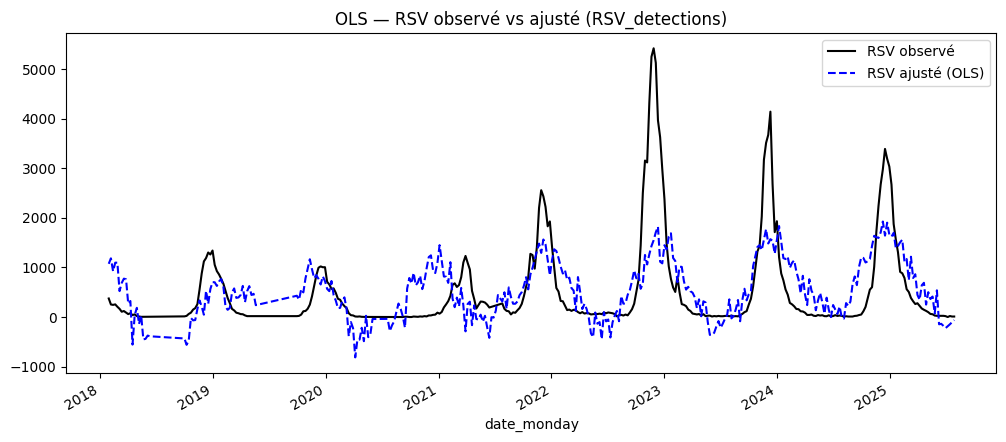

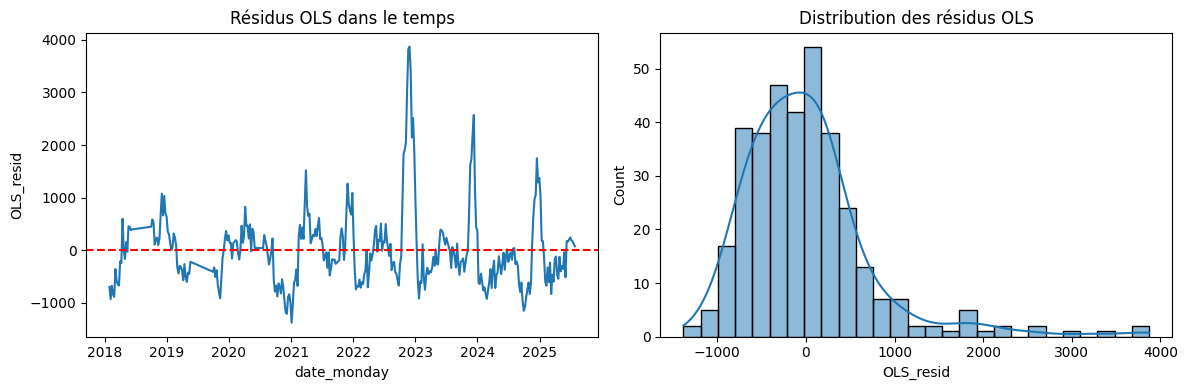

💾 Résumé des coefficients exporté → OLS_results.csv


,Variable,Coefficient,P>|t|,Signif
0,const,1.325143e+03,1.277582e-11,*
20,trend,2.647185e+00,2.601381e-09,*
22,cos52,2.740963e+02,1.811016e-05,*
21,sin52,2.116761e+02,9.456348e-03,*
17,tmin,4.029228e+05,5.809206e-02,
5,coviprev_vaccines_enfants,-5.279923e-08,5.810765e-02,
19,tmean,-8.057884e+05,5.810970e-02,
7,coviprev_eviter_les_regrupements,-6.866780e-08,5.811469e-02,
6,coviprev_aeration_du_logement,-7.013169e-08,5.811507e-02,
1,vacc_dose1,-1.309700e-05,5.811527e-02,


In [9]:
# ==========================================
# 📈 BLOC 4 — Modèle OLS (robuste & traçable)
# ==========================================
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Variables ---
OLS_X = EXOG + ["trend", "sin52", "cos52"]
OLS_X = [c for c in OLS_X if c in data.columns]

# --- Extraction ---
X = data[OLS_X].copy()
y = data[TARGET].astype(float)

# --- Détection & nettoyage complet des NaN/inf ---
invalid_counts = X.isna().sum()
invalid_counts = invalid_counts[invalid_counts > 0]

if len(invalid_counts) > 0:
    print("⚠️ Variables contenant encore des NaN :")
    print(invalid_counts)

# Remplace NaN et inf restants par la médiane colonne
X = X.replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    if X[c].isna().any():
        median_val = np.nanmedian(X[c])
        if np.isnan(median_val):
            # Si toute la colonne est NaN, on remplace par 0
            median_val = 0
        X[c] = X[c].fillna(median_val)

# Double vérif
assert np.isfinite(X.to_numpy()).all(), "Encore des NaN/inf après nettoyage !"

# --- Ajout de la constante et ajustement du modèle ---
X = sm.add_constant(X, has_constant="add")
ols_model = sm.OLS(y, X).fit()

print("📊 RÉSUMÉ DU MODÈLE OLS\n" + "="*80)
print(ols_model.summary())

# ==========================================
# 📉 BLOC 5 — Visualisation & diagnostics
# ==========================================
data["OLS_fitted"] = ols_model.fittedvalues
data["OLS_resid"] = ols_model.resid

# RSV observé vs ajusté
fig, ax = plt.subplots(figsize=(12, 5))
data[TARGET].plot(ax=ax, label="RSV observé", color="black")
data["OLS_fitted"].plot(ax=ax, label="RSV ajusté (OLS)", linestyle="--", color="blue")
ax.set_title(f"OLS — RSV observé vs ajusté ({TARGET})")
ax.legend()
plt.show()

# Résidus temporels et distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=data.index, y=data["OLS_resid"], ax=axes[0])
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_title("Résidus OLS dans le temps")

sns.histplot(data["OLS_resid"], kde=True, ax=axes[1])
axes[1].set_title("Distribution des résidus OLS")

plt.tight_layout()
plt.show()

# ==========================================
# 💾 Export des coefficients
# ==========================================
ols_results = pd.DataFrame({
    "Variable": ols_model.params.index,
    "Coefficient": ols_model.params.values,
    "P>|t|": ols_model.pvalues.values,
    "Signif": np.where(ols_model.pvalues < 0.05, "*", "")
})
ols_results.to_csv("OLS_results.csv", index=False)
print("💾 Résumé des coefficients exporté → OLS_results.csv")

ols_results.sort_values("P>|t|").head(10)


In [10]:
# ==========================================
# 🧠 BLOC 6 — Diagnostic de multicolinéarité (VIF)
# ==========================================
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# --- Préparation des données propres ---
X_vif = data[OLS_X].copy()

# Nettoyage inf / NaN
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
for c in X_vif.columns:
    if X_vif[c].isna().any():
        X_vif[c] = X_vif[c].fillna(X_vif[c].median() if not np.isnan(X_vif[c].median()) else 0)

# --- Calcul des VIF ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# --- Classement et interprétation ---
vif_data = vif_data.sort_values("VIF", ascending=False)
print("📈 VARIANCE INFLATION FACTORS (VIF)\n" + "="*60)
display(vif_data)

# --- Interprétation rapide ---
print("\n💡 Interprétation :")
print("• VIF < 5  → corrélation acceptable ✅")
print("• 5 ≤ VIF < 10 → corrélation modérée ⚠️ (à surveiller)")
print("• VIF ≥ 10 → forte multicolinéarité 🚨 (à simplifier)")

# --- Suggestion automatique de simplification ---
high_vif_vars = vif_data.loc[vif_data["VIF"] >= 10, "Variable"].tolist()
if high_vif_vars:
    print("\n🚨 Variables fortement corrélées détectées :", ", ".join(high_vif_vars))
    print("👉 Suggestion : supprimer les variables redondantes parmi celles-ci ou regrouper leurs effets (ex: moyenne thermique, score MNP global).")
else:
    print("\n✅ Aucune multicolinéarité critique détectée (toutes VIF < 10).")


📈 VARIANCE INFLATION FACTORS (VIF)


,Variable,VIF
18,tmean,2.272353e+10
17,tmax,9.998212e+09
16,tmin,2.667609e+09
12,mob_residential,3.438092e+01
14,mob_transit_stations,2.901768e+01
15,mob_workplaces,2.437416e+01
13,mob_retail_and_recreation,2.263323e+01
11,mob_parks,1.587237e+01
10,mob_grocery_and_pharmacy,7.292200e+00
19,trend,4.789366e+00



💡 Interprétation :
• VIF < 5  → corrélation acceptable ✅
• 5 ≤ VIF < 10 → corrélation modérée ⚠️ (à surveiller)
• VIF ≥ 10 → forte multicolinéarité 🚨 (à simplifier)

🚨 Variables fortement corrélées détectées : tmean, tmax, tmin, mob_residential, mob_transit_stations, mob_workplaces, mob_retail_and_recreation, mob_parks
👉 Suggestion : supprimer les variables redondantes parmi celles-ci ou regrouper leurs effets (ex: moyenne thermique, score MNP global).


In [11]:
# ==========================================
# ⚙️ BLOC 7 — OLS simplifié (après diagnostic VIF)
# ==========================================

# 1️⃣ Choix des variables à conserver
KEEP_VARS = [
    "tmean",          # une seule météo
    "mob_workplaces", # représentative mobilité
    "vacc_complet",   # principale métrique vaccinale
    "coviprev_lavage_des_mains",  # comportement représentatif
    "trend", "sin52", "cos52"     # structure temporelle
]

OLS_X_simplified = [c for c in KEEP_VARS if c in data.columns]

# 2️⃣ Nettoyage NaN / inf
X_simpl = data[OLS_X_simplified].copy().replace([np.inf, -np.inf], np.nan)
for c in X_simpl.columns:
    X_simpl[c] = X_simpl[c].fillna(X_simpl[c].median() if not np.isnan(X_simpl[c].median()) else 0)

y = data[TARGET].astype(float)

# 3️⃣ Ajustement
X_simpl = sm.add_constant(X_simpl, has_constant="add")
ols_simpl = sm.OLS(y, X_simpl).fit()

print("📊 RÉSUMÉ DU MODÈLE OLS SIMPLIFIÉ\n" + "="*80)
print(ols_simpl.summary())

# 4️⃣ Comparaison R² avec le modèle complet
print(f"\nComparaison R² : complet={ols_model.rsquared:.3f} → simplifié={ols_simpl.rsquared:.3f}")


📊 RÉSUMÉ DU MODÈLE OLS SIMPLIFIÉ
                            OLS Regression Results                            
Dep. Variable:         RSV_detections   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     38.25
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           3.26e-31
Time:                        20:54:43   Log-Likelihood:                -2826.7
No. Observations:                 352   AIC:                             5665.
Df Residuals:                     346   BIC:                             5689.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

📏 Durbin–Watson = 0.160

🔎 Test de Ljung–Box (autocorrélation globale) :


,lb_stat,lb_pvalue
5,860.567578,9.091473e-184
10,896.870438,3.002818e-186
20,1014.796280,2.728483e-202
40,1091.033773,1.034317e-202


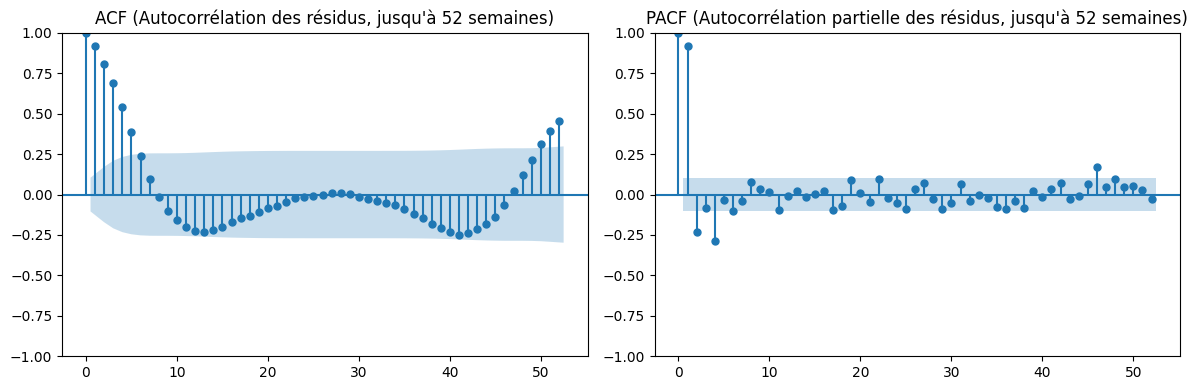

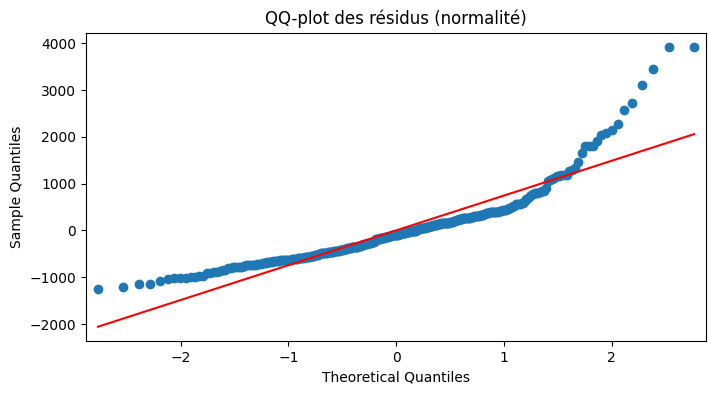


🧠 Interprétation : ⚠️ Autocorrélation positive très forte des résidus.
→ Le test de Ljung–Box confirme une dépendance temporelle significative.


In [12]:
# ==========================================
# 🧪 BLOC 8 — Diagnostic des résidus (Durbin–Watson, Ljung–Box, ACF/PACF)
# ==========================================
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

# --- Extraction des résidus ---
resid = ols_simpl.resid

# --- Test Durbin–Watson ---
dw_stat = sm.stats.stattools.durbin_watson(resid)
print(f"📏 Durbin–Watson = {dw_stat:.3f}")

# --- Test Ljung–Box ---
lb_test = acorr_ljungbox(resid, lags=[5, 10, 20, 40], return_df=True)
print("\n🔎 Test de Ljung–Box (autocorrélation globale) :")
display(lb_test)

# --- Graphiques ACF / PACF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid, ax=axes[0], lags=52)
axes[0].set_title("ACF (Autocorrélation des résidus, jusqu'à 52 semaines)")
plot_pacf(resid, ax=axes[1], lags=52)
axes[1].set_title("PACF (Autocorrélation partielle des résidus, jusqu'à 52 semaines)")
plt.tight_layout()
plt.show()

# --- Distribution des résidus ---
fig, ax = plt.subplots(figsize=(8, 4))
sm.qqplot(resid, line='s', ax=ax)
ax.set_title("QQ-plot des résidus (normalité)")
plt.show()

# --- Résumé interprétatif ---
if dw_stat < 1:
    dw_text = "⚠️ Autocorrélation positive très forte des résidus."
elif 1 <= dw_stat <= 1.5:
    dw_text = "⚠️ Autocorrélation positive modérée."
elif 1.5 < dw_stat < 2.5:
    dw_text = "✅ Pas d’autocorrélation significative."
else:
    dw_text = "⚠️ Autocorrélation négative."

print(f"\n🧠 Interprétation : {dw_text}")

if (lb_test['lb_pvalue'] < 0.05).any():
    print("→ Le test de Ljung–Box confirme une dépendance temporelle significative.")
else:
    print("→ Pas d’autocorrélation globale détectée selon Ljung–Box.")


📊 RÉSUMÉ DU MODÈLE ITS
                            OLS Regression Results                            
Dep. Variable:         RSV_detections   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     4.937
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.10e-06
Time:                        20:54:43   Log-Likelihood:                -2808.9
No. Observations:                 352   AIC:                             5640.
Df Residuals:                     341   BIC:                             5682.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

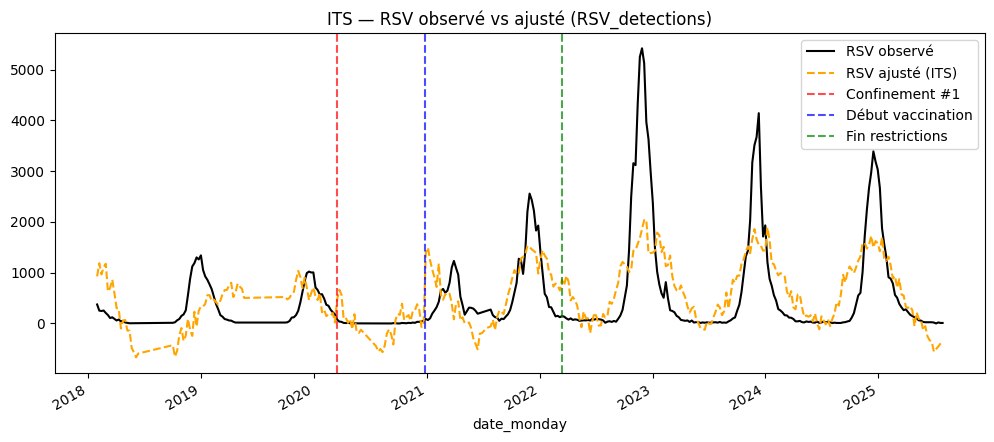

In [13]:
# ==========================================
# ⛔ BLOC 9 — Interrupted Time Series (ITS) — Version compatible
# ==========================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

its = data.copy()

# --- Dates d'interventions ---
d_lock1 = pd.Timestamp("2020-03-16")
d_vacc  = pd.Timestamp("2020-12-27")
d_end   = pd.Timestamp("2022-03-14")

# --- Variable de temps (indexée de 0 à n-1)
its["time"] = np.arange(len(its))

# --- Variables d'intervention binaire ---
its["post_lock1"] = (its.index >= d_lock1).astype(int)
its["post_vacc"]  = (its.index >= d_vacc).astype(int)
its["post_end"]   = (its.index >= d_end).astype(int)

# --- Trouver l'indice le plus proche (compatible pandas >=2.0)
def nearest_index(idx, date):
    return (np.abs(idx - date)).argmin()

idx_lock1 = nearest_index(its.index, d_lock1)
idx_vacc  = nearest_index(its.index, d_vacc)
idx_end   = nearest_index(its.index, d_end)

# --- Pentes après intervention (interaction temps × post) ---
its["time_post_lock1"] = (its["time"] - its["time"].iloc[idx_lock1]).clip(lower=0)
its["time_post_vacc"]  = (its["time"] - its["time"].iloc[idx_vacc]).clip(lower=0)
its["time_post_end"]   = (its["time"] - its["time"].iloc[idx_end]).clip(lower=0)

# --- Variables explicatives ITS ---
ITS_X = [
    "tmean", "vacc_complet", "coviprev_lavage_des_mains",
    "trend", "sin52", "cos52",
    "post_lock1", "time_post_lock1",
    "post_vacc", "time_post_vacc",
    "post_end", "time_post_end"
]
ITS_X = [c for c in ITS_X if c in its.columns]

# --- Nettoyage NaN / inf ---
X_its = its[ITS_X].copy().replace([np.inf, -np.inf], np.nan)
for c in X_its.columns:
    X_its[c] = X_its[c].fillna(X_its[c].median() if not np.isnan(X_its[c].median()) else 0)

y_its = its[TARGET].astype(float)

# --- Ajustement ITS (robuste à l’autocorrélation) ---
X_its = sm.add_constant(X_its, has_constant="add")
its_model = sm.OLS(y_its, X_its).fit(cov_type="HAC", cov_kwds={"maxlags": 4})

print("📊 RÉSUMÉ DU MODÈLE ITS\n" + "="*80)
print(its_model.summary())

# --- Prédiction et résidus ---
its["ITS_fitted"] = its_model.fittedvalues
its["ITS_resid"] = its_model.resid

# --- Graphique comparatif ---
fig, ax = plt.subplots(figsize=(12, 5))
its[TARGET].plot(ax=ax, label="RSV observé", color="black")
its["ITS_fitted"].plot(ax=ax, label="RSV ajusté (ITS)", linestyle="--", color="orange")

# Lignes verticales pour les interventions
ax.axvline(d_lock1, color="red", linestyle="--", alpha=0.7, label="Confinement #1")
ax.axvline(d_vacc, color="blue", linestyle="--", alpha=0.7, label="Début vaccination")
ax.axvline(d_end, color="green", linestyle="--", alpha=0.7, label="Fin restrictions")

ax.set_title(f"ITS — RSV observé vs ajusté ({TARGET})")
ax.legend()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                     RSV_detections   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -2114.626
Date:                            Thu, 30 Oct 2025   AIC                           4253.253
Time:                                    20:54:56   BIC                           4299.129
Sample:                                01-29-2018   HQIC                          4271.537
                                     - 07-28-2025                                         
Covariance Type:                              opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
tmean                                8.6090      5.904      1.458     

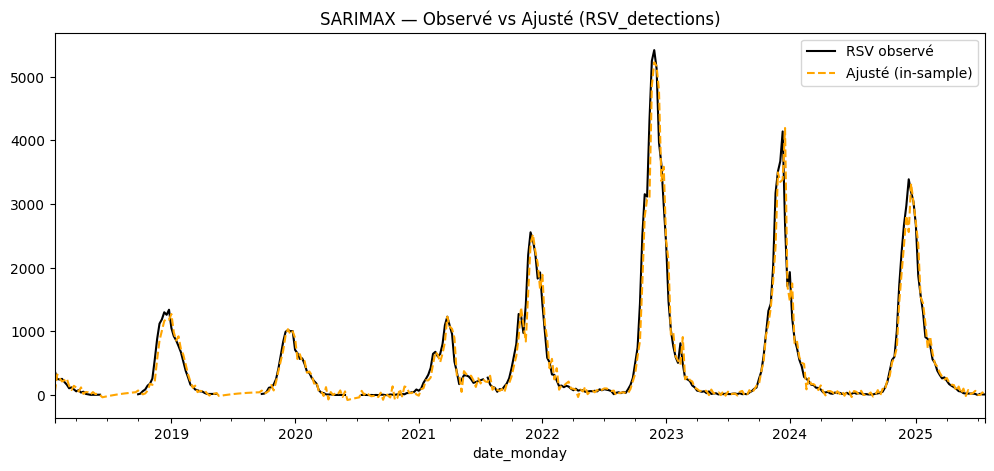

In [14]:
# ==========================================
# 🔁 BLOC 10 — SARIMAX (entraînement avec DatetimeIndex correct)
# ==========================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Étape 1 : S'assurer que les dates sont bien reconnues ---
data = data.copy()
data.index = pd.to_datetime(data.index)
data = data.asfreq("W-MON")  # impose une fréquence hebdomadaire régulière

# --- Étape 2 : Préparation endog/exog ---
SARIMAX_EXOG = [
    "tmean",
    "mob_workplaces",
    "mob_transit_stations",
    "mob_retail_and_recreation",
    "coviprev_port_du_masque",
    "coviprev_eviter_les_regrupements",
    "coviprev_vaccines_adultes",
]


SARIMAX_EXOG = [c for c in SARIMAX_EXOG if c in data.columns]

endog = data[TARGET].astype(float)
exog = data[SARIMAX_EXOG].copy().replace([np.inf, -np.inf], np.nan)
for c in exog.columns:
    med = np.nanmedian(exog[c])
    exog[c] = exog[c].fillna(med if not np.isnan(med) else 0)
exog.index = endog.index  # synchronisation stricte

# --- Étape 3 : Entraînement du modèle ---
sarimax_model = SARIMAX(
    endog=endog,
    exog=exog[SARIMAX_EXOG],
    order=(1,0,1),
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


print(sarimax_model.summary())
print(f"📉 AIC = {sarimax_model.aic:.1f}")

# --- Étape 4 : Prédictions in-sample ---
data["SARIMAX_fitted"] = sarimax_model.fittedvalues
data["SARIMAX_resid"] = endog - data["SARIMAX_fitted"]

fig, ax = plt.subplots(figsize=(12,5))
endog.plot(ax=ax, label="RSV observé", color="black")
data["SARIMAX_fitted"].plot(ax=ax, label="Ajusté (in-sample)", linestyle="--", color="orange")
ax.set_title(f"SARIMAX — Observé vs Ajusté ({TARGET})")
ax.legend(); plt.show()

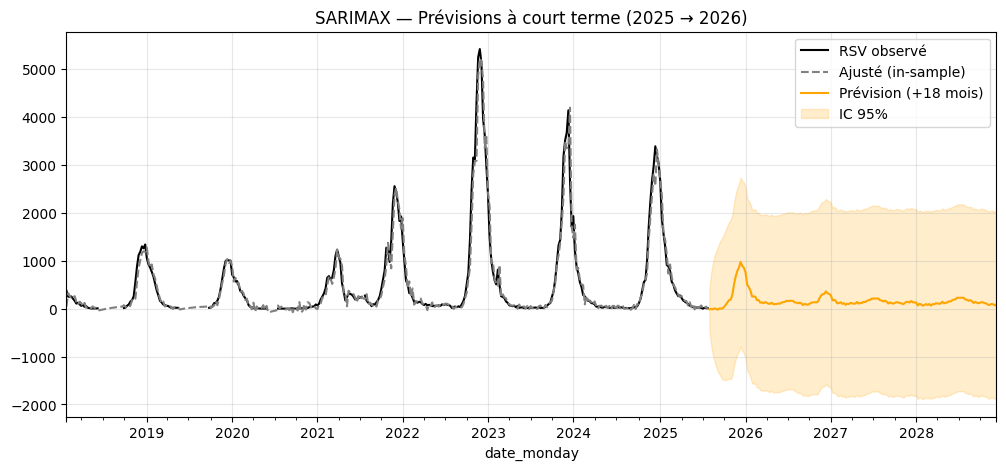

In [24]:
# ==========================================
# 🔮 BLOC 11 — Prévisions à court terme (robuste et aligné)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Sécuriser l’index temporel
data = data.copy()
data.index = pd.to_datetime(data.index)
data = data.asfreq("W-MON")

# 2️⃣ Synchroniser endog / exog
endog = data[TARGET].astype(float)
exog = data[SARIMAX_EXOG].copy().replace([np.inf, -np.inf], np.nan)
for c in exog.columns:
    med = np.nanmedian(exog[c])
    exog[c] = exog[c].fillna(med if not np.isnan(med) else 0)
exog.index = endog.index

# 3️⃣ Préparation de l’horizon futur
h = 176  # semaines (~1,5 an)
last_date = data.index.max()
future_index = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=h, freq="W-MON")

# Extension saisonnière (copie du dernier cycle annuel)
def seasonal_extend(col, base, period=52):
    s = base[col].dropna()
    return pd.Series([s.iloc[-period + (i % period)] if len(s) >= period else s.iloc[-1] for i in range(h)],
                     index=future_index)

future_exog = pd.DataFrame(index=future_index)
for c in SARIMAX_EXOG:
    if c in exog.columns:
        future_exog[c] = seasonal_extend(c, exog)

# 4️⃣ Prévisions
pred_out = sarimax_model.get_forecast(steps=h, exog=future_exog)
fc_mean = pred_out.predicted_mean
fc_int = pred_out.conf_int()

# 5️⃣ Graphique clair
fig, ax = plt.subplots(figsize=(12, 5))
endog.plot(ax=ax, label="RSV observé", color="black")
data["SARIMAX_fitted"].plot(ax=ax, label="Ajusté (in-sample)", linestyle="--", color="gray")
fc_mean.plot(ax=ax, label="Prévision (+18 mois)", color="orange")

ax.fill_between(fc_int.index, fc_int.iloc[:, 0], fc_int.iloc[:, 1],
                color="orange", alpha=0.2, label="IC 95%")
ax.set_title("SARIMAX — Prévisions à court terme (2025 → 2026)")
ax.legend(); ax.grid(alpha=0.3)
plt.show()


In [16]:
# ✅ Forcer un DatetimeIndex clair avant SARIMAX
endog = data[TARGET].astype(float)
endog.index = pd.to_datetime(endog.index)  # important pour éviter 1970

exog = data[SARIMAX_EXOG].copy().replace([np.inf, -np.inf], np.nan)
for c in exog.columns:
    med = np.nanmedian(exog[c])
    exog[c] = exog[c].fillna(med if not np.isnan(med) else 0)
exog.index = endog.index  # synchronisation stricte


In [25]:
# ==========================================
# 🧪 BLOC 12 — Scénarios contrefactuels (robuste)
# ==========================================
def exog_scenario(exog_base, scenario):
    ex = exog_base.copy()

    if scenario == "NoVacc":
        for c in vacc_cols_all:
            if c in ex.columns:
                ref = df.loc[mask_2019_df, c].mean()
                ex[c] = ref if not np.isnan(ref) else 0

    elif scenario == "NoMNP":
        for c in mnp_cols_all:
            if c in ex.columns:
                ref = df.loc[mask_2019_df, c].mean()
                ex[c] = ref if not np.isnan(ref) else ex[c]

    elif scenario == "HighMNP":
        for c in mnp_cols_all:
            if c in ex.columns:
                ref = df.loc[mask_2020_2021_df, c].quantile(0.9)
                ex[c] = ref if not np.isnan(ref) else ex[c]

    # nettoyage
    for c in ex.columns:
        med = np.nanmedian(ex[c])
        ex[c] = ex[c].fillna(med if not np.isnan(med) else 0)
    return ex

base_pred = sarimax_model.get_prediction(exog=exog).predicted_mean

sc_names = ["NoVacc", "NoMNP", "HighMNP"]
sc_preds = {sc: sarimax_model.get_prediction(exog=exog_scenario(exog, sc)).predicted_mean for sc in sc_names}

cf = pd.DataFrame({
    f"{TARGET}_obs": endog,
    "SARIMAX_hat_real": base_pred,
}, index=data.index)

for sc in sc_names:
    cf[f"SARIMAX_{sc}"] = sc_preds[sc]
    cf[f"Δ_{sc}"] = cf[f"SARIMAX_{sc}"] - cf["SARIMAX_hat_real"]

print("✅ Scénarios contrefactuels générés :", list(sc_preds.keys()))
cf.tail(5)

✅ Scénarios contrefactuels générés : ['NoVacc', 'NoMNP', 'HighMNP']


,RSV_detections_obs,SARIMAX_hat_real,SARIMAX_NoVacc,Δ_NoVacc,SARIMAX_NoMNP,Δ_NoMNP,SARIMAX_HighMNP,Δ_HighMNP
date_monday,,,,,,,,
2025-06-30,18.0,67.170039,67.170039,0.0,67.170039,0.0,67.170039,0.0
2025-07-07,0.0,5.814822,5.814822,0.0,5.814822,0.0,5.814822,0.0
2025-07-14,20.0,0.230910,0.230910,0.0,0.230910,0.0,0.230910,0.0
2025-07-21,10.0,42.864889,42.864889,0.0,42.864889,0.0,42.864889,0.0
2025-07-28,10.0,-2.894748,-2.894748,0.0,-2.894748,0.0,-2.894748,0.0


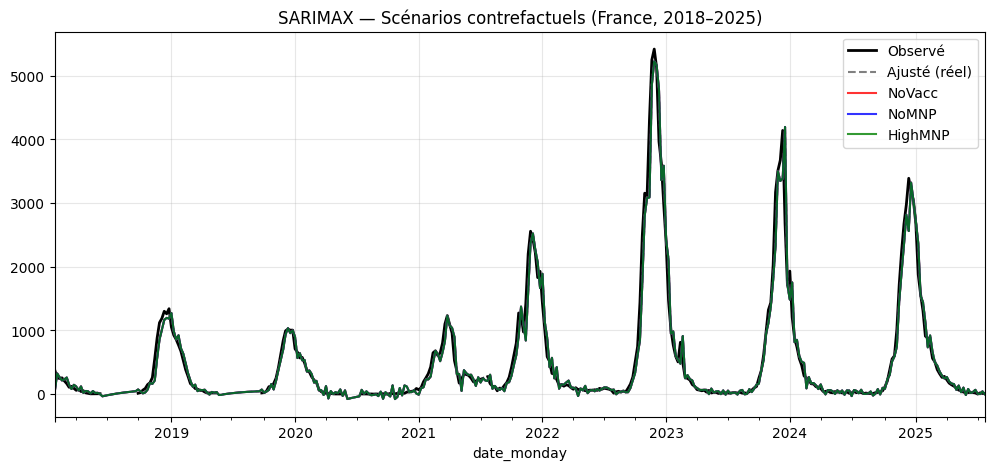

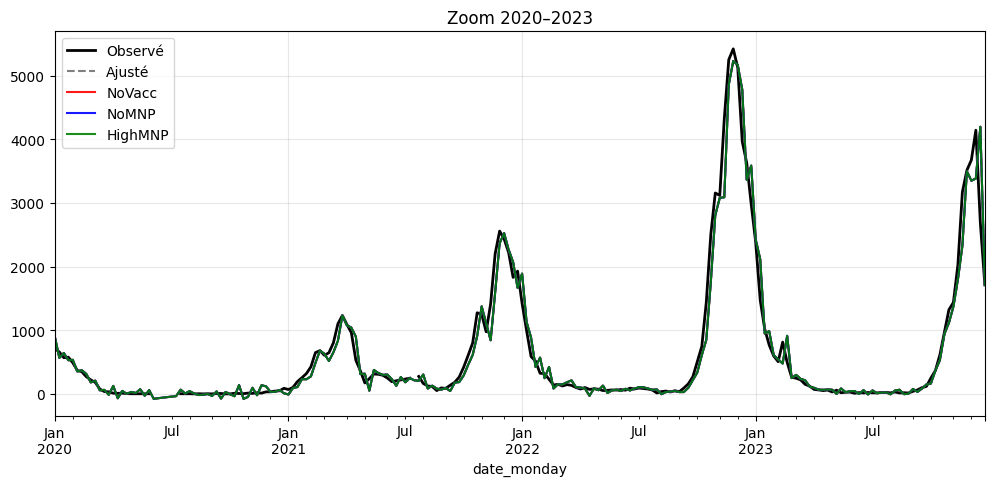

In [26]:
# ==========================================
# 📈 BLOC 13 — Visualisation scénarios SARIMAX
# ==========================================
colors = {"NoVacc": "red", "NoMNP": "blue", "HighMNP": "green"}

fig, ax = plt.subplots(figsize=(12, 5))
cf[f"{TARGET}_obs"].plot(ax=ax, color="black", label="Observé", linewidth=2)
cf["SARIMAX_hat_real"].plot(ax=ax, color="gray", linestyle="--", label="Ajusté (réel)")

for sc, col in colors.items():
    cf[f"SARIMAX_{sc}"].plot(ax=ax, color=col, alpha=0.8, label=sc)

ax.set_title("SARIMAX — Scénarios contrefactuels (France, 2018–2025)")
ax.legend(); ax.grid(alpha=0.3)
plt.show()

# Zoom 2020–2023
fig, ax = plt.subplots(figsize=(12, 5))
cf.loc["2020":"2023", f"{TARGET}_obs"].plot(ax=ax, color="black", linewidth=2, label="Observé")
cf.loc["2020":"2023", "SARIMAX_hat_real"].plot(ax=ax, color="gray", linestyle="--", label="Ajusté")
for sc, col in colors.items():
    cf.loc["2020":"2023", f"SARIMAX_{sc}"].plot(ax=ax, color=col, alpha=0.9, label=sc)
ax.legend(); ax.set_title("Zoom 2020–2023"); ax.grid(alpha=0.3)
plt.show()


In [27]:
# ==========================================
# ❄️ BLOC 14 — Impact saisonnier cumulé (corrigé)
# ==========================================
impact = []
for year in range(2019, 2026):
    saison = f"{year-1}-{year}"
    start = f"{year-1}-09-01"
    end = f"{year}-04-30"
    mask = (cf.index >= start) & (cf.index <= end)
    total_obs = cf.loc[mask, f"{TARGET}_obs"].sum()
    row = {"Saison": saison, "RSV_obs": total_obs}
    for sc in ["NoVacc", "NoMNP", "HighMNP"]:
        row[f"Δ_{sc}_cumul"] = cf.loc[mask, f"Δ_{sc}"].sum()
    impact.append(row)

impact_df = pd.DataFrame(impact).set_index("Saison")
display(impact_df.style.background_gradient(cmap="coolwarm", axis=None))


,RSV_obs,Δ_NoVacc_cumul,Δ_NoMNP_cumul,Δ_HighMNP_cumul
Saison,,,,
2018-2019,14537.000000,0.000000,0.000000,0.000000
2019-2020,11225.000000,0.000000,0.000000,0.000000
2020-2021,10348.000000,0.000000,0.000000,0.000000
2021-2022,26088.000000,0.000000,0.000000,0.000000
2022-2023,52000.000000,0.000000,0.000000,0.000000
2023-2024,33518.000000,0.000000,0.000000,0.000000
2024-2025,35214.000000,0.000000,0.000000,0.000000
